# New Cluster Model Dev + Analysis
### Author: Emmanuel Paalam
### Date: 7/25/2025

This notebook documents a renewed process of clustering and analyzing student data from the ELS:2002 study for a CAP4770 group project. It covers data extraction, cleaning, imputation, encoding, dimensionality reduction (PCA), clustering (DBSCAN), and evaluation of cluster performance in relation to student dropout status. The goal is to explore whether selected variables can effectively distinguish between dropouts and non-dropouts using unsupervised learning techniques. This new notebook was made after change of mind of the author in how to cluster the data in light of class imbalance in F1EVERDO.

The following reserve codes are used throughout the ECB. This description is added to the first variable of each section to helpusers understand the meaning of each reserve code.

- -1: "Don't know" represents respondents who indicated that they didn't know the answer to the question.

- -2: "Refused" represents respondents who indicated that they refused to answer the question

- -3: "Item legitimate skip/NA" is filled for questions that are not administered based on routing logic; i.e., the items are not applicable based on responses to prior questions.

- -4: "Nonrespondent" is filled for all variables across the entire questionnaire when a sample member did not respond to the questionnaire.

- -5: "Out of range" represents questionnaire respondents who reported values that are out of range.

- -6: "Multiple response" represents hard copy questionnaire respondents who reported more than one response for an item that requires only one response.

- -7: "Partial interview-breakoff" is filled for questions that are not answered because the respondent does not wish to continue the interview or they have run out of time. This also includes particular items that are not included on an abbreviated version questionnaire.

- -8: "Survey component legitimate skip/NA" is filled for all items within a survey component for sample members who were not administered that component by design for one of the following reasons: 1) the component was not administered based on their status (e.g., transfer students did not receive certain items on the in-school survey), 2) the sample member was not a part of the study at the time of administration (e.g., first follow-up freshened sample members were by definition not eligible for the base-year survey), or 3) the sample member was not capable of completing the survey component (e.g., students who were questionnaire-ineligible due to a language barrier or disability at the time of the survey).

- -9: "Missing" is filled for questions that are not answered when the routing suggests that a response should have been provided.

## Call MySQL table into environment

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# --- 1. Database Connection Details ---
# These should be the same as in your cleaning notebook.
db_config = {
    'user': 'root',
    'password': 'orbit4*papers', # Replace with your password
    'host': '127.0.0.1', # This means your local machine
}

db_name = 'els2002_selected_columns'
table_name = 'els_2002_data'

# --- 2. Create the Connection Engine ---
# This engine is what allows pandas to communicate with your database.
try:
    engine_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_name}"
    engine = create_engine(engine_string)
    print("✅ Connection engine created successfully.")

except Exception as e:
    print(f"❌ Failed to create engine: {e}")

# --- 3. Write and Execute the SQL Query ---
# This is a simple query to select everything from your table.
query = f"SELECT * FROM {table_name}"

try:
    # Use pandas to execute the query and load the result into a DataFrame
    df = pd.read_sql_query(query, engine)
    
    print(f"✅ Data successfully loaded from '{table_name}' into a DataFrame.")
    print("DataFrame shape:", df.shape)
    
except Exception as e:
    print(f"❌ Failed to load data from SQL: {e}")

engine.dispose()  # Close the connection to the database

del db_config, query, table_name, db_name, engine_string

✅ Connection engine created successfully.
✅ Data successfully loaded from 'els_2002_data' into a DataFrame.
DataFrame shape: (14654, 42)


Alright, so at this point we've brought the table made off of the 42 selected variables from the raw ELS:2002 study (`pretable_clean.ipynv`) back in. Let's now work on the missing values that are present on them, in order to more successfully perform cluster analysis, and more generally prep the data for clustering.

## Post-subset + pre-PCA processing

DBSCAN is generally not recommended for mixed data, which is the style of dataset that we're working with here, and is intended to be used with numerical data only. To account for this, I opt to perform encoding on the categorical data in our "raw" subset to convert all categorical columns to a numerical, algorithm-friendly format.

However, this ends up boosting the number of columns by a significant amount due to the types of encoding performed (e.g. one-hot encoding, which divvys up nominal columns to make binary vectors out of them), so I also engage with PCA to reduce dimensional complexity for clustering.

### Explicit NA search & replacement

In [2]:
import numpy as np
df_withnan = df.applymap(lambda x: np.nan if x in [-1, -2, -3, -4, -5, -6, -7, -8, -9] else x)

for row in df_withnan['BYGRDRPT']: # this column expresses missings differently from the others
    if row in [98, 99]:
        df_withnan['BYGRDRPT'] = df_withnan['BYGRDRPT'].replace(row, np.nan)
del row

df_withnan.isna().sum()

C:\Users\epaal\AppData\Local\Temp\ipykernel_23104\2864311089.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_withnan = df.applymap(lambda x: np.nan if x in [-1, -2, -3, -4, -5, -6, -7, -8, -9] else x)


STU_ID         0
F1EVERDO       0
F1PNLWT        0
BYTXRSTD       0
BYTXMSTD       0
BYSCHPRG       0
BYGRDRPT    2411
BYS33A      1422
BYS33D      1663
BYS33E      1694
BYS33H      1453
BYHMWRK     1182
BYXTRACU     894
BYS24A      1273
BYS24B      1354
BYS24C      1424
BYS38C      1461
F1S31       1271
BYSTEXP     1948
F1STEXP        0
BYSES1       700
BYS89A      4127
BYS89I      4489
BYS89E      4350
BYS89N      4487
BYS20A      1264
BYS20B      1323
BYS20J      1406
BYS20K      1348
BYS90B      4760
BYS90D      4843
BYS90F      4853
BYS90L      4954
BYS91       5328
BYINCOME       0
F1MOTHED       0
F1FATHED       0
F1OCCUM        0
F1OCCUF        0
BYFCOMP      648
F1FCOMP        0
BYHOMLNG     980
dtype: int64

In [3]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

df_imputed = pd.DataFrame(IterativeImputer(max_iter=10, random_state=0).fit_transform(df_withnan), columns=df_withnan.columns)

del df, df_withnan

In [4]:
df_imputed.isna().sum()

STU_ID      0
F1EVERDO    0
F1PNLWT     0
BYTXRSTD    0
BYTXMSTD    0
BYSCHPRG    0
BYGRDRPT    0
BYS33A      0
BYS33D      0
BYS33E      0
BYS33H      0
BYHMWRK     0
BYXTRACU    0
BYS24A      0
BYS24B      0
BYS24C      0
BYS38C      0
F1S31       0
BYSTEXP     0
F1STEXP     0
BYSES1      0
BYS89A      0
BYS89I      0
BYS89E      0
BYS89N      0
BYS20A      0
BYS20B      0
BYS20J      0
BYS20K      0
BYS90B      0
BYS90D      0
BYS90F      0
BYS90L      0
BYS91       0
BYINCOME    0
F1MOTHED    0
F1FATHED    0
F1OCCUM     0
F1OCCUF     0
BYFCOMP     0
F1FCOMP     0
BYHOMLNG    0
dtype: int64

### Preparatory work
Let's first group columns together for encoding.

In [5]:
no_scale = ['F1EVERDO', 'STU_ID', 'F1PNLWT']

num_cols = ['BYTXRSTD', 'BYTXMSTD', 'BYSES1', 'BYHMWRK', 'BYXTRACU']

ord_cols = ['BYGRDRPT', 'BYS24A', 'BYS24B', 'BYS24C', 'BYS38C', 'F1S31', 'BYSTEXP', 'F1STEXP', 'BYS89A', 'BYS89I', 'BYS89E',
            'BYS89N', 'BYS20A', 'BYS20B', 'BYS20J', 'BYS20K', 'BYS90B', 'BYS90D', 'BYS90F', 'BYS90L', 'BYS91', 'BYINCOME', 'F1MOTHED',
            'F1FATHED', 'BYS33A', 'BYS33D', 'BYS33E', 'BYS33H']
# NOTE: 'BYS33A', 'BYS33D', 'BYS33E', 'BYS33H' are binary but will ordinal encode for simplicity

nom_cols = ['BYSCHPRG', 'F1OCCUM', 'F1OCCUF', 'BYFCOMP', 'F1FCOMP', 'BYHOMLNG']

### Type recasting...

Iterative Imputer is okay with inserting irrational floats into some of our categorical columns that have missings, so let's first round those to better reflect the original column nature, which will otherwise confuse the encoders.

In [6]:
for col in nom_cols + ord_cols:
    df_imputed[col] = df_imputed[col].round(0).astype('int64')
del col

And F1EVERDO is a binary variable.

In [7]:
df_imputed['F1EVERDO'] = df_imputed['F1EVERDO'].astype('int64')  # Ensure binary column is int64

### Early variable exclusion to ensure proper clustering

Remove variables we don't want to process (e.g. F1EVERDO, which is meant for post-cluster labelling - real glad we recast this one as well beforehand). What isn't popped is each study participant's exploratory data for clustering to be based off of.

Due to the format of this dataset, we can easily recombine ID and target variables with any reformatted versions of the dataset left after popping them due to row-order preservation throughout the remaining parts of this clustering process.

In [8]:
weight_var = df_imputed.pop('F1PNLWT')
id_var = df_imputed.pop('STU_ID')
target_var = df_imputed.pop('F1EVERDO')

### Time to encode!
And then we'll actually do PCA.

In [9]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(), ord_cols),
        ('nom', OneHotEncoder(sparse_output=False), nom_cols),
        ('num_cols', StandardScaler(), num_cols)
    ], remainder='passthrough') # leave the no_scale columns as is

df_processed = preprocessor.fit_transform(df_imputed)

del ord_cols,nom_cols, num_cols, no_scale

## PCA

Simple as that. This results in a 36-column ndarray, much shorter than the 96-column array of `df_processed`.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Retain 95% of variance
df_pca = pca.fit_transform(df_processed)

## Clustering

Having reduced our encoded data to its primary components, we can now go ahead with attempting clustering students into groups. Since we aren't using K-means, instead of looking for the proper *k*-value, I'll look for *eps* as used in DBSCAN.

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

k = df_imputed.shape[1] * 2 # best practice is to set k to 2x the number of features.
                            # For the sake of observing the original number of features, we will use 2x the number of features
                            # in the imputed but not processed data.

### Define eps

One of the ways to determine a reasonable *eps* value (maximum distance between two points for one to be considered as in the neighborhood of the other) when you don't have any domain knowledge of what to set it as is through the use of a *k*-distance graph. This graph visualizes the overall density distribution of our raw data, communicating where the "core", "border", and "noise" points are. By locating the "border" points, we can approximate a good *eps*.

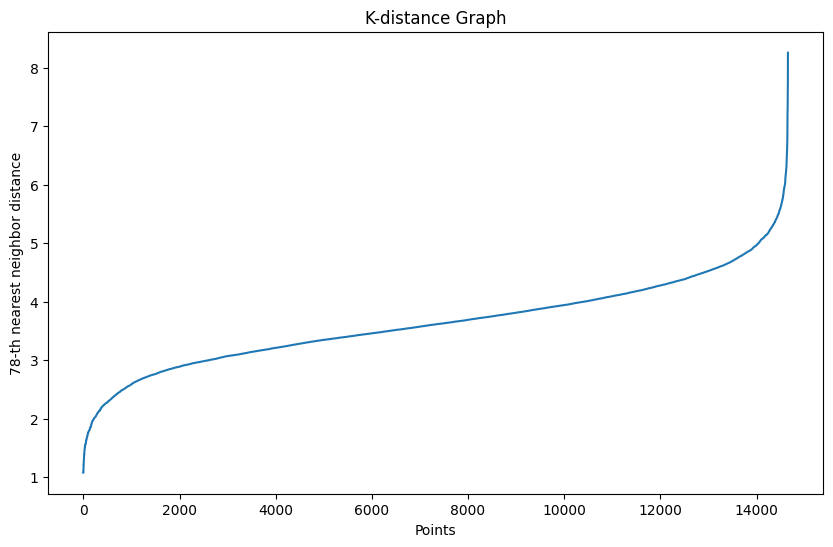

In [28]:
knn = NearestNeighbors(n_neighbors=k)
knn.fit(df_pca)
distances, _ = knn.kneighbors(df_pca)
distances = np.sort(distances[:, 1])  # Sort the distances of the k-nearest neighbors
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.title('K-distance Graph')
plt.show()

Looks like almost all of the points in our processed data seem to be "core", or close enough to each other that most of them fail to act as good indicators for where a cluster border would be. This is actually a hopeful sign, as the data was mostly comprised of non-dropouts: with a big primary cluster, we may be able to distinguish between non-dropouts and dropouts by allowing the dropouts to act as outliers to it.

Let's zoom in to get our *eps*.

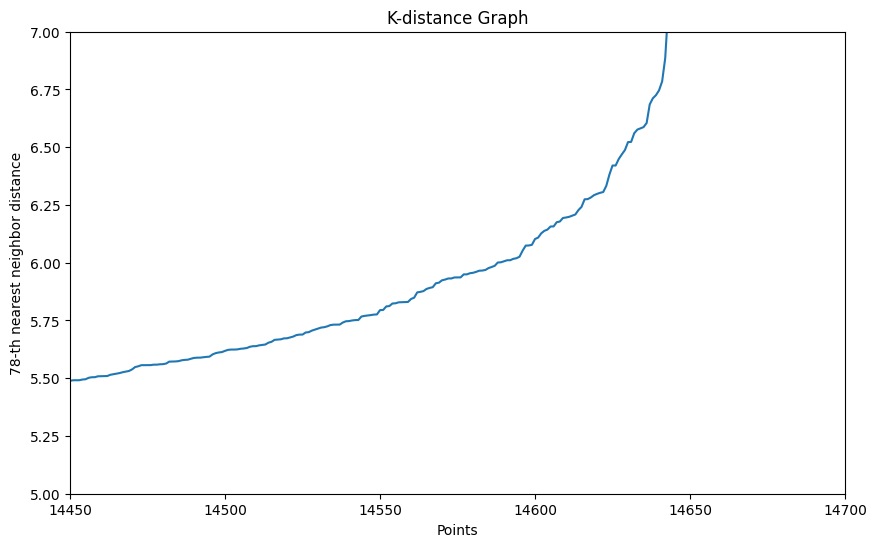

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.title('K-distance Graph')
plt.xlim(14450, 14700)  # Zoom in to points 1000 to 1500
plt.ylim(5, 7)
plt.show()

In respect to the dataset's original size, a more generous bordering distance of `eps = 5.75` will be used.

### DBSCAN w/found eps value

Nothing much to this - with our found `eps` value, we can now obtain cluster labels and see how many non/dropouts are grouped in both.

In [53]:
from sklearn.cluster import DBSCAN

# Let's assume your elbow plot suggested an eps of around 4.5 (you will need to adjust this)
dbscan = DBSCAN(eps=5.75, min_samples=k)
cluster_labels = dbscan.fit_predict(df_pca)

## Evaluation

Hooray, we're done with DBSCAN! Now let's evaluate the cluster(s) generated by the algorithm.

In [54]:
df_results = pd.DataFrame({
    'STU_ID': id_var,
    'F1EVERDO': target_var,
    'Cluster Labels': cluster_labels,
    'Weight': weight_var
})

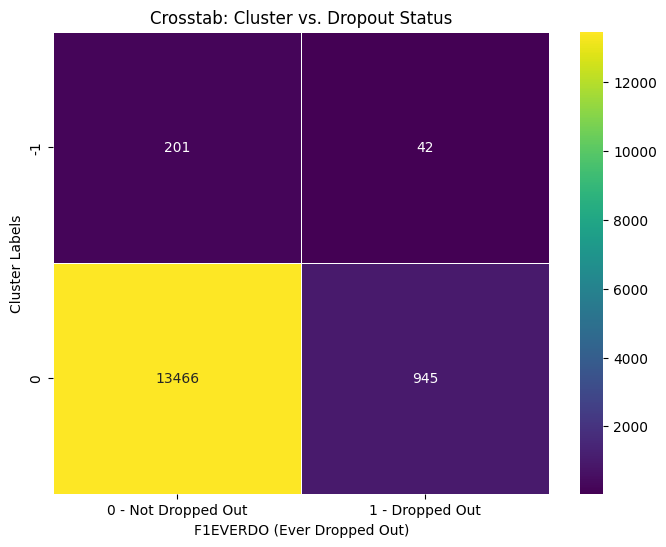

In [55]:
import seaborn as sns

basic_crosstab = pd.crosstab(df_results['Cluster Labels'], df_results['F1EVERDO'])

plt.figure(figsize=(8, 6))
sns.heatmap(
    basic_crosstab,
    annot=True,          # Display the numbers in the cells
    fmt='.0f',           # Format numbers as integers (no decimals)
    cmap='viridis',      # A color-blind friendly colormap
    linewidths=.5,
    xticklabels = ['0 - Not Dropped Out', '1 - Dropped Out']#,
    # yticklabels = ['Cluster 1', 'Cluster 2']
)
plt.title('Crosstab: Cluster vs. Dropout Status')
# plt.ylabel('Cluster')
plt.xlabel('F1EVERDO (Ever Dropped Out)')
plt.show()

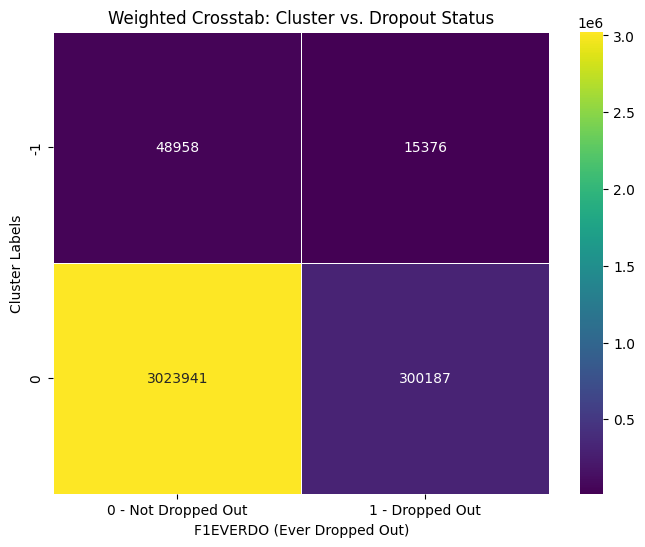

In [56]:
weighted_crosstab = pd.crosstab(df_results['Cluster Labels'], df_results['F1EVERDO'], values=df_results['Weight'], aggfunc='sum')

plt.figure(figsize=(8, 6))
sns.heatmap(
    weighted_crosstab,
    annot=True,          # Display the numbers in the cells
    fmt='.0f',           # Format numbers as integers (no decimals)
    cmap='viridis',      # A color-blind friendly colormap
    linewidths=.5,
    xticklabels = ['0 - Not Dropped Out', '1 - Dropped Out']#,
    # yticklabels = ['Cluster 1', 'Cluster 2']
)
plt.title('Weighted Crosstab: Cluster vs. Dropout Status')
# plt.ylabel('Cluster')
plt.xlabel('F1EVERDO (Ever Dropped Out)')
plt.show()

Observing the weights per student participant in the original study, rather than row count as depicted in the first heatmap:
- One gigantic cluster was generated, with outliers to it represented with the cluster label of `-1`.
- Non-Dropouts (Column 0): The vast majority (3,023,941) of the U.S. sophomore student population from 2002 were placed inside the cluster, with a tiny fraction (48,958) registered as outliers.
- Dropouts (Column 1): The vast majority of these students (300,187) were also placed in Cluster 1, with a smaller but still significant group (15,376) registered as outliers.

This is relatively proportional to the number of sample non/dropout sample subjects in each cluster as depicted in the first heatmap.

The key takeaway is that the DBSCAN algorithm, based on our selected exploratory variables, could not find a pattern to effectively isolate dropouts. It placed most students, regardless of dropout status, into one massive cluster, with more balance between dropouts and non-dropouts actually found outside of the cluster. This result strongly suggests that the exploratory variables used, while logical, do not contain strong enough signals to naturally separate students into groups that align with their dropout status. 